In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "S1Fa-like"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [7]:
USE_FULL_DF = True

if USE_FULL_DF:
    dataset = pd.read_csv(df_path)
else:
    dataset_ = pd.read_csv(df_path)
    r = min(5000/len(dataset_), 1)
    _, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)
dataset.head()

,id,sequence,length,class
0,Achn154221,MGSIGGGGVLILAEVGEVLGVLGGRGRPLGKRERWVLDLKWLKSHR...,375,1
1,Achn194261,MDYEAEFADHNPPSFDRMENVIKNPEVKGFNPGLIVLILVGGLLLT...,90,1
2,AA93G00134,MADDFAGNVESKGLNPGMIVLLVIGGLLLTFLVGNFILYTYAQKNL...,73,1
3,AHYPO_001833-RA,VYCLGNSPLLGLIHHANLKGQREGVQFGSYGAVDEVEAKGLNPGLI...,101,1
4,AHYPO_006308-RA,MILGLEGAFVTLTGLNLGLRHNKAVEEAEAKGFNPGLIVLLVIGGF...,93,1


In [8]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [9]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".keras", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [10]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
549,0.000000,0.0,0.0,0.006579,0.0,0.003289,0.003289,0.003289,0.000000,0.003289,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
315,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.014493,0.000000,0.014493,...,0.0,0.0,0.0,0.0,0.0,0.014493,0.000000,0.0,0.0,0.0
102,0.000000,0.0,0.0,0.012658,0.0,0.000000,0.000000,0.000000,0.000000,0.012658,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
107,0.026316,0.0,0.0,0.013158,0.0,0.013158,0.000000,0.000000,0.013158,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.013158,0.0,0.0,0.0
62,0.026316,0.0,0.0,0.013158,0.0,0.013158,0.000000,0.000000,0.013158,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.026316,0.0,0.0,0.0


In [11]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (559, 431)
X_test: (140, 431)
y_train: (559,)
y_test: (140,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [12]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         110,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 153,857 (601.00 KB)

 Trainable params: 153,857 (601.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 2s 469ms/step - accuracy: 0.4531 - loss: 0.6935

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6248 - loss: 0.6903 - val_accuracy: 0.9821 - val_loss: 0.6728


Epoch 2/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9531 - loss: 0.6732

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9679 - loss: 0.6641 - val_accuracy: 0.9732 - val_loss: 0.6120


Epoch 3/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9375 - loss: 0.6204

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9544 - loss: 0.5935 - val_accuracy: 0.9821 - val_loss: 0.4760


Epoch 4/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9531 - loss: 0.4951

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9619 - loss: 0.4473 - val_accuracy: 0.9821 - val_loss: 0.2582


Epoch 5/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9844 - loss: 0.2680

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9742 - loss: 0.2418 - val_accuracy: 0.9821 - val_loss: 0.0981


Epoch 6/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9844 - loss: 0.1191

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9711 - loss: 0.1184 - val_accuracy: 0.9821 - val_loss: 0.0599


Epoch 7/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9219 - loss: 0.1600

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9638 - loss: 0.0901 - val_accuracy: 0.9821 - val_loss: 0.0466


Epoch 8/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0502

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9775 - loss: 0.0499 - val_accuracy: 0.9911 - val_loss: 0.0570


Epoch 9/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0402

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9911 - loss: 0.0359 - val_accuracy: 0.9911 - val_loss: 0.0393


Epoch 10/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0321

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9873 - loss: 0.0319 - val_accuracy: 0.9911 - val_loss: 0.0531


Epoch 11/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0134

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9973 - loss: 0.0176 - val_accuracy: 0.9911 - val_loss: 0.0562


Epoch 12/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0243

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0201 - val_accuracy: 0.9911 - val_loss: 0.0246


Epoch 13/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0052

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9965 - loss: 0.0174 - val_accuracy: 0.9911 - val_loss: 0.0233


Epoch 14/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0090

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0112 - val_accuracy: 0.9911 - val_loss: 0.0443


Epoch 15/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0128

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9989 - loss: 0.0106 - val_accuracy: 0.9911 - val_loss: 0.0082


Epoch 16/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0021

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0049 - val_accuracy: 0.9911 - val_loss: 0.0561


Epoch 17/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0079

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9966 - loss: 0.0135 - val_accuracy: 0.9911 - val_loss: 0.0166


Epoch 18/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0171

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9947 - loss: 0.0078 - val_accuracy: 0.9911 - val_loss: 0.0107



[Train Accuracy: 99.78% - Test Accuracy: 99.29%]


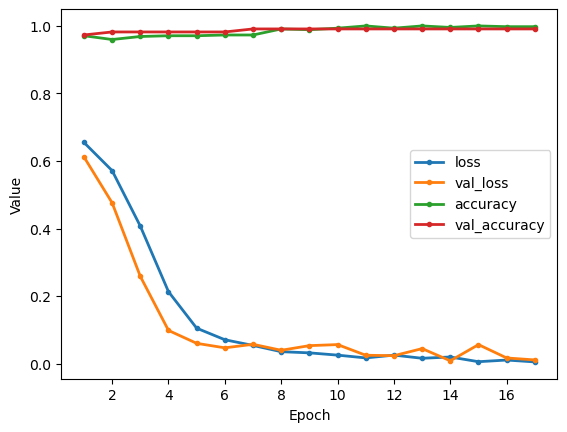

In [13]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [14]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k2, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [15]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
549,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
315,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
107,0.013333,0.0,0.0,0.013333,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62,0.013333,0.0,0.0,0.013333,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (559, 8026)
X_test: (140, 8026)
y_train: (559,)
y_test: (140,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [17]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,054,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,098,177 (8.00 MB)

 Trainable params: 2,098,177 (8.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 2s 479ms/step - accuracy: 0.5000 - loss: 0.6931

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5064 - loss: 0.6905 - val_accuracy: 0.5357 - val_loss: 0.6734


Epoch 2/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6719 - loss: 0.6718

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8052 - loss: 0.6630 - val_accuracy: 1.0000 - val_loss: 0.6128


Epoch 3/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9531 - loss: 0.5985

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9679 - loss: 0.5818 - val_accuracy: 0.9911 - val_loss: 0.4818


Epoch 4/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9844 - loss: 0.4825

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9839 - loss: 0.4348 - val_accuracy: 0.9911 - val_loss: 0.2936


Epoch 5/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9844 - loss: 0.3322

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9842 - loss: 0.2633 - val_accuracy: 0.9911 - val_loss: 0.1301


Epoch 6/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9688 - loss: 0.1164

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9857 - loss: 0.1037 - val_accuracy: 0.9911 - val_loss: 0.0450


Epoch 7/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0445

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9989 - loss: 0.0339 - val_accuracy: 0.9911 - val_loss: 0.0236


Epoch 8/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0101

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9977 - loss: 0.0132 - val_accuracy: 0.9911 - val_loss: 0.0166


Epoch 9/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0072

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9994 - loss: 0.0080 - val_accuracy: 0.9911 - val_loss: 0.0214


Epoch 10/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0011

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.9911 - val_loss: 0.0145


Epoch 11/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0013

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.9911 - val_loss: 0.0138


Epoch 12/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0011

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.9911 - val_loss: 0.0173



[Train Accuracy: 100.00% - Test Accuracy: 97.86%]


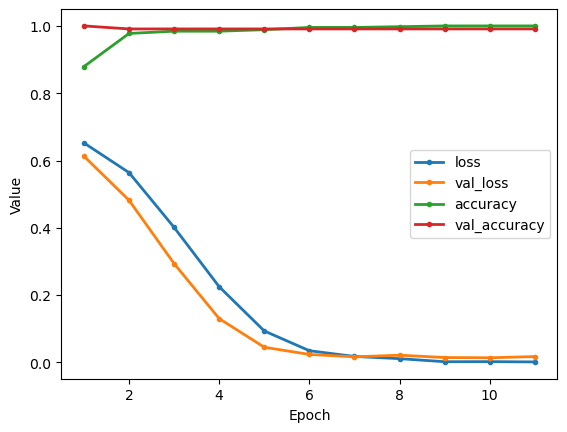

In [18]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [19]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k3, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [20]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYTG,YYTT,YYVP,YYWA,YYYH,YYYQ,YYYR,YYYT,YYYX,YYYY
549,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
315,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
107,0.0,0.0,0.0,0.013514,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62,0.0,0.0,0.0,0.013514,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [22]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      18,299,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,340,353 (69.96 MB)

 Trainable params: 18,340,353 (69.96 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 2s 451ms/step - accuracy: 0.5156 - loss: 0.6932

3/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5460 - loss: 0.6929 

5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6071 - loss: 0.6923

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6510 - loss: 0.6916

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.6664 - loss: 0.6914 - val_accuracy: 0.9821 - val_loss: 0.6777


Epoch 2/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9688 - loss: 0.6781

3/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9731 - loss: 0.6763

5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9701 - loss: 0.6743

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9684 - loss: 0.6717

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9676 - loss: 0.6707 - val_accuracy: 0.9821 - val_loss: 0.6345


Epoch 3/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9688 - loss: 0.6337

3/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9609 - loss: 0.6295

5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9584 - loss: 0.6243

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9596 - loss: 0.6180

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9602 - loss: 0.6155 - val_accuracy: 0.9821 - val_loss: 0.5411


Epoch 4/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9531 - loss: 0.5415

3/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9670 - loss: 0.5267

5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9746 - loss: 0.5137

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9777 - loss: 0.5026

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9788 - loss: 0.4985 - val_accuracy: 0.9821 - val_loss: 0.3848


Epoch 5/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 1.0000 - loss: 0.3709

3/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9983 - loss: 0.3572

5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9976 - loss: 0.3438

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9976 - loss: 0.3296

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9976 - loss: 0.3244 - val_accuracy: 0.9821 - val_loss: 0.2051


Epoch 6/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.1756

3/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 0.1694

5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 0.1579

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9997 - loss: 0.1479

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9994 - loss: 0.1445 - val_accuracy: 0.9821 - val_loss: 0.0975


Epoch 7/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 1.0000 - loss: 0.0603

3/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9957 - loss: 0.0592

5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9960 - loss: 0.0554

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9964 - loss: 0.0513

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9966 - loss: 0.0499 - val_accuracy: 0.9821 - val_loss: 0.0624


Epoch 8/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 1.0000 - loss: 0.0169

3/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 1.0000 - loss: 0.0154

5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 0.0148

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 0.0141

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 1.0000 - loss: 0.0138 - val_accuracy: 0.9821 - val_loss: 0.0559


Epoch 9/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 1.0000 - loss: 0.0052

3/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 0.0064

5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 0.0060

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 0.0057

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 1.0000 - loss: 0.0056 - val_accuracy: 0.9821 - val_loss: 0.0566


Epoch 10/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 1.0000 - loss: 0.0021

3/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 0.0023

5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 0.0023

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 0.0024

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 0.9821 - val_loss: 0.0606


Epoch 11/100


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 1.0000 - loss: 0.0014

3/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 0.0017

5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 0.0019

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 0.0019

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.9821 - val_loss: 0.0607



[Train Accuracy: 100.00% - Test Accuracy: 97.14%]


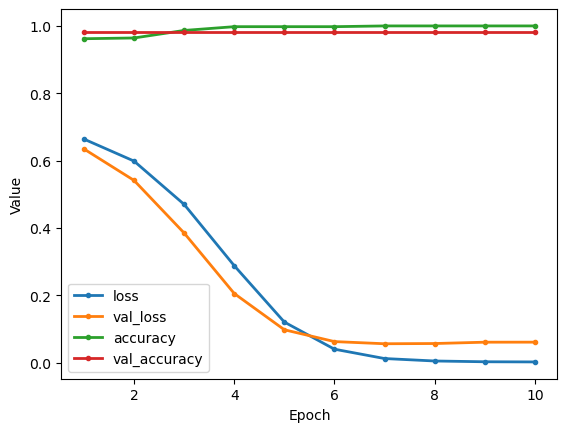

In [23]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [24]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k4, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [25]:
report.save()

Report saved as Output/Reports/S1Fa-like/report_C04GAED5.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [26]:
"""k = 5
X, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()"""

"k = 5\nX, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)\nX_test.head()"

In [27]:
"""NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]"""

'NUM_CLASS  = 1\nSEQ_LENGTH = X_train.shape[1]'

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [28]:
"""name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'name="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n# Evaluate and sc

In [29]:
"""VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"""

"VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"

In [30]:
"""VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
report.save('end')"""

'VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) \nreport.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])\nreport.save(\'end\')'

In [31]:
# END

In [32]:
######################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################